In [1]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import time
from copy import deepcopy

In [24]:
sigma = np.array([0.25, 0.35])
na = len(sigma)
correl = 0.5

K = 1

In [25]:
T = 1
n = 365

p_uu = p_dd = (1 + correl) / 4
p_ud = p_du = (1 - correl) / 4

In [26]:
def compute_S(num_nodes_total: int, num_nodes: int, sigma: np.array, T_total: float):
    dt = T_total / num_nodes_total
    step_sizes = sigma * dt**0.5
    X = np.array([step_sizes[0] * (2 * np.arange(num_nodes+1) - num_nodes).reshape(num_nodes+1, -1).repeat(num_nodes+1, 1),
                  step_sizes[1] * (2 * np.arange(num_nodes+1) - num_nodes).reshape(-1, num_nodes+1).repeat(num_nodes+1, 0)])
    S = np.exp(X)
    S[0] = S[0] * np.exp(-0.5 * sigma[0]**2 * num_nodes * dt)
    S[1] = S[1] * np.exp(-0.5 * sigma[1]**2 * num_nodes * dt)
    return S

In [165]:
def simulate_S(Ts, num_sim, seed=2023):
    np.random.seed(seed=seed)
    dTs = np.diff(Ts, n=1, prepend=[0])
    S = np.zeros((len(Ts), num_sim, na))
    for i in range(len(Ts)):
        X0 = np.random.normal(size=num_sim)
        X1 = correl * X0 + (1-correl**2)**0.5 * np.random.normal(size=num_sim)
        S[i, :, 0] = np.exp(sigma[0] * dTs[i]**0.5 * X0 - 0.5*sigma[0]**2*dTs[i])
        S[i, :, 1] = np.exp(sigma[1] * dTs[i]**0.5 * X1 - 0.5*sigma[1]**2*dTs[i])
        if i > 0:
            S[i] = S[i] * S[i-1]
    return S

In [28]:
def max_vec(*matrices):
    m = matrices[0]
    for mm in matrices[1:]:
        m = np.maximum(m, mm)
    return m

## tree

In [100]:
T = 1
n = 365

In [121]:
Kv0 = 0.01
Kv_num = 101

Kv_step = (K*1.01 - Kv0) / (Kv_num-1)
Kv = np.linspace(Kv0, K*1.01, Kv_num)

Km = np.ones((Kv_num, n+1, n+1))
for i in range(Kv_num):
    Km[i] = Kv[i] * Km[i]
# Kv

In [122]:
S = compute_S(n, n, sigma, T)
payoff_no_shout = max_vec(0, 0.5*(S[0]+S[1]) - K, 0.5*(S[0]+S[1]) - 0.5*(K + S[0]), 0.5*(S[0]+S[1]) - 0.5*(K + S[1]))
payoff_shouted0 = max_vec(0, 0.5*(S[0]+S[1]) - 0.5*(K + Km), 0.5*(S[0]+S[1]) - 0.5*(S[1] + Km))
payoff_shouted1 = max_vec(0, 0.5*(S[0]+S[1]) - 0.5*(K + Km), 0.5*(S[0]+S[1]) - 0.5*(S[0] + Km))
payoff_shouted_both = max_vec(0, 0.5*(S[0]+S[1]) - Km)
payoff_shouted_both.shape

(101, 366, 366)

In [123]:
def shout_payoff_first(index_shout):
    Kmn_lower_index = (S[index_shout] - Kv0) // Kv_step
    Kmn_lower_index = (np.maximum(0, np.minimum(Kmn_lower_index, Kv_num-2))).astype(int)
    Kmn_lower_weight = 1.0 - (S[index_shout] - (Kv0 + Kmn_lower_index * Kv_step)) / Kv_step
    Kmn_lower_weight = np.minimum(1.0, np.maximum(0.0, Kmn_lower_weight))

    master_payoff = payoff_shouted0 if index_shout == 0 else payoff_shouted1
    j, k = np.ogrid[:master_payoff.shape[1], :master_payoff.shape[2]]
    shout_payoff_lower_dd = master_payoff[Kmn_lower_index, j[:-1, :], k[:, :-1]]
    shout_payoff_upper_dd = master_payoff[1+Kmn_lower_index, j[:-1, :], k[:, :-1]]
    shout_payoff_lower_du = master_payoff[Kmn_lower_index, j[:-1, :], k[:, 1:]]
    shout_payoff_upper_du = master_payoff[1+Kmn_lower_index, j[:-1, :], k[:, 1:]]
    shout_payoff_lower_ud = master_payoff[Kmn_lower_index, j[1:, :], k[:, :-1]]
    shout_payoff_upper_ud = master_payoff[1+Kmn_lower_index, j[1:, :], k[:, :-1]]
    shout_payoff_lower_uu = master_payoff[Kmn_lower_index, j[1:, :], k[:, 1:]]
    shout_payoff_upper_uu = master_payoff[1+Kmn_lower_index, j[1:, :], k[:, 1:]]

    shout_payoff = p_dd * (Kmn_lower_weight * shout_payoff_lower_dd + (1.0 - Kmn_lower_weight) * shout_payoff_upper_dd) +\
                    p_du * (Kmn_lower_weight * shout_payoff_lower_du + (1.0 - Kmn_lower_weight) * shout_payoff_upper_du) +\
                    p_ud * (Kmn_lower_weight * shout_payoff_lower_ud + (1.0 - Kmn_lower_weight) * shout_payoff_upper_ud) +\
                    p_uu * (Kmn_lower_weight * shout_payoff_lower_uu + (1.0 - Kmn_lower_weight) * shout_payoff_upper_uu)

    return shout_payoff

def shout_payoff_second(index_shout, Km):
    Km = Km[:, :nt+1, :nt+1]
    Kmn = 0.5 * (Km + S[index_shout])
    Kmn_lower_index = (Kmn - Kv0) // Kv_step
    Kmn_lower_index = (np.maximum(0, np.minimum(Kmn_lower_index, Kv_num-2))).astype(int)
    Kmn_lower_weight = 1.0 - (Kmn - (Kv0 + Kmn_lower_index * Kv_step)) / Kv_step
    Kmn_lower_weight = np.minimum(1.0, np.maximum(0.0, Kmn_lower_weight))

    j, k = np.ogrid[:payoff_shouted_both.shape[1], :payoff_shouted_both.shape[2]]
    shout_payoff_lower_dd = payoff_shouted_both[Kmn_lower_index, j[:-1, :], k[:, :-1]]
    shout_payoff_upper_dd = payoff_shouted_both[1+Kmn_lower_index, j[:-1, :], k[:, :-1]]
    shout_payoff_lower_du = payoff_shouted_both[Kmn_lower_index, j[:-1, :], k[:, 1:]]
    shout_payoff_upper_du = payoff_shouted_both[1+Kmn_lower_index, j[:-1, :], k[:, 1:]]
    shout_payoff_lower_ud = payoff_shouted_both[Kmn_lower_index, j[1:, :], k[:, :-1]]
    shout_payoff_upper_ud = payoff_shouted_both[1+Kmn_lower_index, j[1:, :], k[:, :-1]]
    shout_payoff_lower_uu = payoff_shouted_both[Kmn_lower_index, j[1:, :], k[:, 1:]]
    shout_payoff_upper_uu = payoff_shouted_both[1+Kmn_lower_index, j[1:, :], k[:, 1:]]
    
    shout_payoff = p_dd * (Kmn_lower_weight * shout_payoff_lower_dd + (1.0 - Kmn_lower_weight) * shout_payoff_upper_dd) +\
                    p_du * (Kmn_lower_weight * shout_payoff_lower_du + (1.0 - Kmn_lower_weight) * shout_payoff_upper_du) +\
                    p_ud * (Kmn_lower_weight * shout_payoff_lower_ud + (1.0 - Kmn_lower_weight) * shout_payoff_upper_ud) +\
                    p_uu * (Kmn_lower_weight * shout_payoff_lower_uu + (1.0 - Kmn_lower_weight) * shout_payoff_upper_uu)

    return shout_payoff
    
def back_propagate(some_payoff: np.array, probs: list):
    p_dd, p_du, p_ud, p_uu = probs
    return p_dd * some_payoff[:-1, :-1] + p_du * some_payoff[:-1, 1:] + p_ud * some_payoff[1:, :-1] + p_uu * some_payoff[1:, 1:]

def back_propagate2(some_payoff: np.array, probs: list):
    p_dd, p_du, p_ud, p_uu = probs
    return p_dd * some_payoff[:, :-1, :-1] + p_du * some_payoff[:, :-1, 1:] + p_ud * some_payoff[:, 1:, :-1] + p_uu * some_payoff[:, 1:, 1:]

n_e = [7*i for i in range(1,52)] + [365]
#n_e = [180, 365]
plot_exercise_region = False

for nt in range(n-1, 0, -1):
    S = compute_S(n, nt, sigma, T)

    payoff_no_shout_no_shout = back_propagate(payoff_no_shout, [p_dd, p_du, p_ud, p_uu])
    payoff_shouted0_no_shout = back_propagate2(payoff_shouted0, [p_dd, p_du, p_ud, p_uu])
    payoff_shouted1_no_shout = back_propagate2(payoff_shouted1, [p_dd, p_du, p_ud, p_uu])
    if nt in n_e:
        payoff_no_shout_shout0 = shout_payoff_first(0)
        payoff_no_shout_shout1 = shout_payoff_first(1)
        payoff_shouted0_shout1 = shout_payoff_second(1, Km)
        payoff_shouted1_shout0 = shout_payoff_second(0, Km)
        if plot_exercise_region:
            break
        payoff_no_shout = max_vec(payoff_no_shout_no_shout, payoff_no_shout_shout0, payoff_no_shout_shout1)
        payoff_shouted0 = np.maximum(payoff_shouted0_no_shout, payoff_shouted0_shout1)
        payoff_shouted1 = np.maximum(payoff_shouted1_no_shout, payoff_shouted1_shout0)
    else:
        payoff_no_shout = payoff_no_shout_no_shout
        payoff_shouted0 = payoff_shouted0_no_shout
        payoff_shouted1 = payoff_shouted1_no_shout
    payoff_shouted_both = back_propagate2(payoff_shouted_both, [p_dd, p_du, p_ud, p_uu])
    #print(nt)
    
payoff = back_propagate(payoff_no_shout, [p_dd, p_du, p_ud, p_uu])
payoff[0,0]

0.14144363108877384

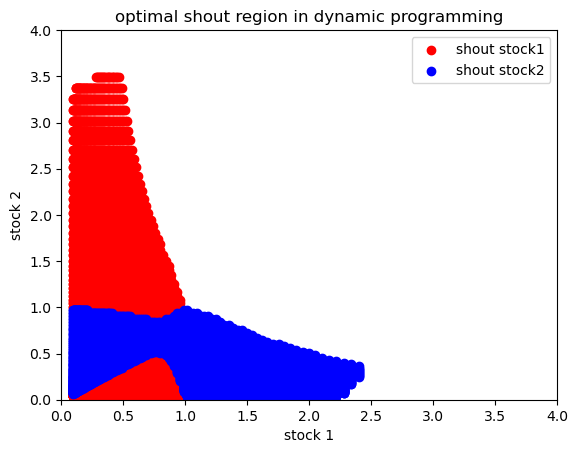

In [114]:
S = compute_S(n, nt, sigma, T)
shout0_x = []
shout0_y = []
shout1_x = []
shout1_y = []
for i in range(nt+1):
    for j in range(nt+1):
        if S[0,i,0]<4 and S[1,0,j]<4:
            if payoff_no_shout_no_shout[i,j] < payoff_no_shout_shout0[i,j] and payoff_no_shout_shout0[i,j] > payoff_no_shout_shout1[i,j]:
                shout0_x.append(S[0,i,0])
                shout0_y.append(S[1,0,j])
            if payoff_no_shout_no_shout[i,j] < payoff_no_shout_shout1[i,j] and payoff_no_shout_shout1[i,j] > payoff_no_shout_shout0[i,j]:
                shout1_x.append(S[0,i,0])
                shout1_y.append(S[1,0,j])
plt.scatter(shout0_x, shout0_y, c="red", label='shout stock1')
plt.scatter(shout1_x, shout1_y, c="blue", label='shout stock2')
plt.title("optimal shout region in dynamic programming")
plt.xlim(0,4)
plt.ylim(0,4)
plt.xlabel("stock 1")
plt.ylabel("stock 2")
plt.legend(loc="upper right")
plt.show()

## American Monte Carlo 

In [182]:
n_e = [7*i for i in range(1, 52)] + [365]
#n_e = [180, 365]
num_sim = 100000
Ts = np.array([i*T/365 for i in n_e])
S = simulate_S(Ts, num_sim=num_sim)

Ks = np.zeros((len(n_e), num_sim, 2))
K0 = np.zeros(num_sim)
K1 = np.zeros(num_sim)

np.random.seed(2023)
for nt in range(1, len(n_e)):
    K0_sel = (K0 == 0) & (S[nt-1, :, 0] < K)
    K1_sel = (K1 == 0) & (S[nt-1, :, 1] < K)
    K0_only = K0_sel & (~K1_sel)
    K_both = K0_sel & K1_sel
    K1_only = K1_sel & (~K0_sel)

    K0[K0_only] = np.where(np.random.choice(2, size=sum(K0_only)) == 0, S[nt-1, K0_only, 0], 0)
    K1[K1_only] = np.where(np.random.choice(2, size=sum(K1_only)) == 0, S[nt-1, K1_only, 1], 0)
    action = np.random.choice(3, size=sum(K_both))
    K0[K_both] = np.where(action == 0, S[nt-1, K_both, 0], 0)
    K1[K_both] = np.where(action == 1, S[nt-1, K_both, 1], 0)

    Ks[nt, :, 0] = deepcopy(K0)
    Ks[nt, :, 1] = deepcopy(K1)

In [183]:
def compute_value(K0e, K1e, S0e, S1e):
    A = 0.5*(S0e+S1e)
    return np.where((K0e>0) & (K1e>0), np.maximum(0, A - 0.5*(K0e+K1e)),
                np.where(K0e>0, np.maximum(0, A - 0.5*(K0e + np.minimum(K, S1e))),
                    np.where(K1e>0, np.maximum(0, A - 0.5*(K1e + np.minimum(K, S0e))),
                        np.where(S1e>S0e, np.maximum(0, A - 0.5*(K + np.minimum(K, S0e))),
                            np.maximum(0, A - 0.5*(K + np.minimum(K, S1e)))))))

def optimalPolicy(i, K0e, K1e, S0e, S1e):
    X = np.vstack([K0e, K1e, S0e, S1e]).T
    F = PolynomialFeatures(degree_features).fit_transform(X)

    values = {}
    values["noShout"] = models["noShout"][i].predict(F)
    values["shout0"] = np.where(K0e == 0, models["shout0"][i].predict(F), values["noShout"])
    values["shout1"] = np.where(K1e == 0, models["shout1"][i].predict(F), values["noShout"])

    sel0 = (K0e == 0) & (S0e < K) & (values["shout0"] > values["noShout"]) & ((S1e > K) | ((S1e < K) & (values["shout0"]>values["shout1"])))
    K0e[sel0] = S0e[sel0]
    sel1 = (K1e == 0) & (S1e < K) & (values["shout1"] > values["noShout"]) & ((S0e > K) | ((S0e < K) & (values["shout0"]<values["shout1"])))
    K1e[sel1] = S1e[sel1]

    return K0e, K1e

def q(action, nt):
    Ks_t = deepcopy(Ks)
    K0 = Ks_t[nt, :, 0]
    K1 = Ks_t[nt, :, 1]

    if action == 'noShout':
        sel = K0 > -1
        K0_eff = deepcopy(K0)
        K1_eff = deepcopy(K1)
    elif action == 'shout0':
        sel = (K0 == 0) & (S[nt, :, 0] < K)
        K0_eff = deepcopy(S[nt, sel, 0])
        K1_eff = deepcopy(K1[sel])
    else:
        sel = (K1 == 0) & (S[nt, :, 1] < K)
        K0_eff = deepcopy(K0[sel])
        K1_eff = deepcopy(S[nt, sel, 1])

    for i in range(nt+1, len(n_e)-1):
        K0_eff, K1_eff = optimalPolicy(i, K0_eff, K1_eff, S[i, sel, 0], S[i, sel, 1])

    values = compute_value(K0_eff, K1_eff, S[-1, sel, 0], S[-1, sel, 1])
    X = np.vstack([Ks_t[nt, sel, 0], Ks_t[nt, sel, 1], S[nt, sel, 0], S[nt, sel, 1]]).T
    return X, values, sel

In [184]:
nt = len(n_e)-2
degree_features = 2

all_actions = ["noShout", "shout0", "shout1"]
models = {action: [None for _ in range(len(n_e)-1)] for action in all_actions}

for nt in range(len(n_e)-2, -1, -1):
    for action in all_actions:
        X, values, _ = q(action, nt)
        F = PolynomialFeatures(degree_features).fit_transform(X)
        models[action][nt] = LinearRegression().fit(F, values)

In [185]:
K0 = np.zeros(num_sim)
K1 = np.zeros(num_sim)

for nt in range(len(n_e) - 1):
    K0, K1 = optimalPolicy(nt, K0, K1, S[nt, :, 0], S[nt, :, 1])

v = compute_value(K0, K1, S[-1,:,0], S[-1,:,1])
sd = np.std(v)/num_sim**0.5
print(np.mean(v), np.mean(v) - 2*sd, np.mean(v)+2*sd)

0.13042662478195946 0.12922305585545785 0.13163019370846107


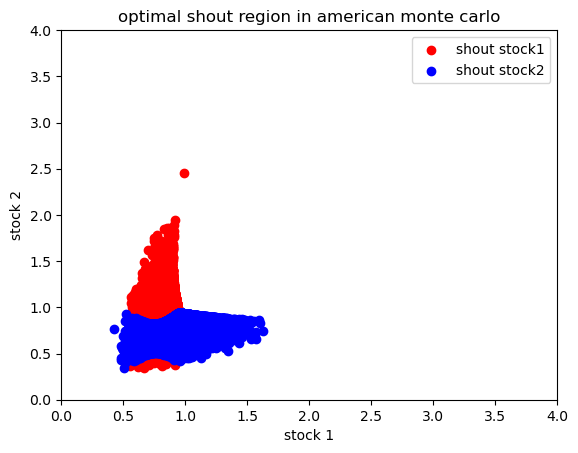

In [177]:
nt = 0
Ks_test = deepcopy(Ks)
K0e = Ks_test[nt, :, 0]
K1e = Ks_test[nt, :, 1]

K0, K1 = optimalPolicy(0, K0e, K1e, S[nt, :, 0], S[nt, :, 1])

shout0_x = []
shout0_y = []
shout1_x = []
shout1_y = []
for i in range(S.shape[1]):
    if K0[i] > 0:
        shout0_x.append(S[0, i, 0])
        shout0_y.append(S[0, i, 1])
    elif K1[i] > 0:
        shout1_x.append(S[0, i, 0])
        shout1_y.append(S[0, i, 1])
        
plt.scatter(shout0_x, shout0_y, c="red", label="shout stock1")
plt.scatter(shout1_x, shout1_y, c="blue", label="shout stock2")
plt.title("optimal shout region in american monte carlo")
plt.xlim(0,4)
plt.ylim(0,4)
plt.xlabel("stock 1")
plt.ylabel("stock 2")
plt.legend(loc="upper right")
plt.show()

## Dynamic Monte Carlo

In [196]:
n_e = [180, 365]
n_e = [7*i for i in range(1, 52)] + [365]
num_sim = 100000
Ts = np.array([i*T/365 for i in n_e])
S = simulate_S(Ts, num_sim=num_sim)

payoff_no_shout_no_shout = np.maximum(0.5*(S[-1, :, 0]+S[-1, :, 1]) - K, 0)
payoff_no_shout_shout0 = np.maximum(0.5*(S[-1, :, 0]+S[-1, :, 1]) - 0.5*(S[-1,:,0]+K), 0)
payoff_no_shout_shout1 = np.maximum(0.5*(S[-1, :, 0]+S[-1, :, 1]) - 0.5*(S[-1,:,1]+K), 0)
payoff_no_shout = max_vec(payoff_no_shout_no_shout, payoff_no_shout_shout0, payoff_no_shout_shout1)

Km = np.repeat(Kv.reshape(1,-1), num_sim, axis=0)
payoff_shouted_both = max_vec(0, 0.5*(S[-1, :, 0]+S[-1, :, 1]).reshape(-1,1) - Km)

payoff_shouted0_no_shout = max_vec(0, 0.5*(S[-1, :, 0]+S[-1,:,1]).reshape(-1,1) - 0.5*(Km+K))
payoff_shouted0_shout = max_vec(0, 0.5*(S[-1, :, 0]+S[-1,:,1]).reshape(-1,1) - 0.5*(Km+S[-1,:,1].reshape(-1,1)))
payoff_shouted0 = max_vec(payoff_shouted0_no_shout, payoff_shouted0_shout)

payoff_shouted1_no_shout = max_vec(0, 0.5*(S[-1, :, 0]+S[-1,:,1]).reshape(-1,1) - 0.5*(Km+K))
payoff_shouted1_shout = max_vec(0, 0.5*(S[-1, :, 0]+S[-1,:,1]).reshape(-1,1) - 0.5*(Km+S[-1,:,0].reshape(-1,1)))
payoff_shouted1 = max_vec(payoff_shouted1_no_shout, payoff_shouted1_shout)

In [197]:
degree_features = 2

for nt in range(len(n_e)-2, -1, -1):
    # state: no_shout

    ## action: shout 0
    sel0 = S[nt, :, 0] < K
    F = PolynomialFeatures(degree_features).fit_transform(S[nt, sel0, :])
    model_no_shout_no_shout = LinearRegression().fit(F, payoff_no_shout[sel0])

    Kvn_lower_index = (S[nt, sel0, 0] - Kv0) // Kv_step
    Kvn_lower_index = (np.maximum(0, np.minimum(Kvn_lower_index, Kv_num-2))).astype(int)
    Kvn_lower_weight = 1.0 - (S[nt, sel0, 0] - (Kv0 + Kvn_lower_index * Kv_step)) / Kv_step
    Kvn_lower_weight = np.minimum(1.0, np.maximum(0.0, Kvn_lower_weight))
    payoff_shouted0_sel0 = payoff_shouted0[sel0, :]
    j = np.ogrid[:payoff_shouted0_sel0.shape[0]]
    payoff_no_shout_shout0 = Kvn_lower_weight * payoff_shouted0_sel0[j, Kvn_lower_index] +\
        (1-Kvn_lower_weight) * payoff_shouted0_sel0[j, 1+Kvn_lower_index]
    model_no_shout_shout0 = LinearRegression().fit(F, payoff_no_shout_shout0)

    sel00 = model_no_shout_shout0.predict(F) > model_no_shout_no_shout.predict(F)
    if not plot_exercise_region:
        payoff_no_shout[sel0] = np.where(sel00, payoff_no_shout_shout0, payoff_no_shout[sel0])

    ## action: shout1
    sel1 = S[nt, :, 1] < K
    F2 = PolynomialFeatures(degree_features).fit_transform(S[nt, sel1, :])
    model_no_shout_no_shout = LinearRegression().fit(F2, payoff_no_shout[sel1])

    Kvn_lower_index = (S[nt, sel1, 1] - Kv0) // Kv_step
    Kvn_lower_index = (np.maximum(0, np.minimum(Kvn_lower_index, Kv_num-2))).astype(int)
    Kvn_lower_weight = 1.0 - (S[nt, sel1, 1] - (Kv0 + Kvn_lower_index * Kv_step)) / Kv_step
    Kvn_lower_weight = np.minimum(1.0, np.maximum(0.0, Kvn_lower_weight))
    payoff_shouted1_sel1 = payoff_shouted1[sel1, :]
    j = np.ogrid[:payoff_shouted1_sel1.shape[0]]
    payoff_no_shout_shout1 = Kvn_lower_weight * payoff_shouted1_sel1[j, Kvn_lower_index] +\
        (1-Kvn_lower_weight) * payoff_shouted1_sel1[j, 1+Kvn_lower_index]
    model_no_shout_shout1 = LinearRegression().fit(F2, payoff_no_shout_shout1)

    sel11 = model_no_shout_shout1.predict(F2) > model_no_shout_no_shout.predict(F2)
    if plot_exercise_region:
        break
    payoff_no_shout[sel1] = np.where(sel11, payoff_no_shout_shout1, payoff_no_shout[sel1])
    
    # state: shouted0
    sel1 = S[nt, :, 1] < K
    F = PolynomialFeatures(degree_features).fit_transform(S[nt, sel1, :])

    Kmn = 0.5*(S[nt, sel1, 1].reshape(-1,1) + Km[sel1])
    Kmn_lower_index = (Kmn - Kv0) // Kv_step
    Kmn_lower_index = (np.maximum(0, np.minimum(Kmn_lower_index, Kv_num-2))).astype(int)
    Kmn_lower_weight = 1.0 - (Kmn - (Kv0 + Kmn_lower_index * Kv_step)) / Kv_step
    Kmn_lower_weight = np.minimum(1.0, np.maximum(0.0, Kmn_lower_weight))
    payoff_shouted_both_sel1 = payoff_shouted_both[sel1, :]
    j = np.array([[i] for i in range(payoff_shouted_both_sel1.shape[0])])
    payoff_shouted0_shout1 = Kmn_lower_weight * payoff_shouted_both_sel1[j, Kmn_lower_index] +\
        (1.0 - Kmn_lower_weight) * payoff_shouted_both_sel1[j, 1+Kmn_lower_index]

    for i in range(Kv_num):
        model_shouted0_no_shout = LinearRegression().fit(F, payoff_shouted0[sel1, i])
        model_shouted0_shout1 = LinearRegression().fit(F, payoff_shouted0_shout1[:, i])
        sel11 = model_shouted0_shout1.predict(F) > model_shouted0_no_shout.predict(F)
        payoff_shouted0[sel1, i] = np.where(sel11, payoff_shouted0_shout1[:, i], payoff_shouted0[sel1, i])

    ## state: shouted1
    sel0 = S[nt, :, 0] < K
    F = PolynomialFeatures(degree_features).fit_transform(S[nt, sel0, :])

    Kmn = 0.5*(S[nt, sel0, 0].reshape(-1,1) + Km[sel0])
    Kmn_lower_index = (Kmn - Kv0) // Kv_step
    Kmn_lower_index = (np.maximum(0, np.minimum(Kmn_lower_index, Kv_num-2))).astype(int)
    Kmn_lower_weight = 1.0 - (Kmn - (Kv0 + Kmn_lower_index * Kv_step)) / Kv_step
    Kmn_lower_weight = np.minimum(1.0, np.maximum(0.0, Kmn_lower_weight))
    payoff_shouted_both_sel0 = payoff_shouted_both[sel0, :]
    j = np.array([[i] for i in range(payoff_shouted_both_sel0.shape[0])])
    payoff_shouted1_shout0 = Kmn_lower_weight * payoff_shouted_both_sel0[j, Kmn_lower_index] +\
        (1.0 - Kmn_lower_weight) * payoff_shouted_both_sel0[j, 1+Kmn_lower_index]

    for i in range(Kv_num):
        model_shouted1_no_shout = LinearRegression().fit(F, payoff_shouted1[sel0, i])
        model_shouted1_shout0 = LinearRegression().fit(F, payoff_shouted1_shout0[:, i])
        sel00 = model_shouted1_shout0.predict(F) > model_shouted1_no_shout.predict(F)
        payoff_shouted1[sel0, i] = np.where(sel00, payoff_shouted1_shout0[:, i], payoff_shouted1[sel0, i])

    print(nt)

print(np.mean(payoff_no_shout))
sd = np.std(payoff_no_shout)/num_sim**0.5
print(np.mean(payoff_no_shout) - 2*sd, np.mean(payoff_no_shout)+2*sd)



50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
0.14109826001426795
0.13994265436875866 0.14225386565977724
